In [1]:
# import necessary library
import os
import sys
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sn
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from sklearn.metrics import euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sys.path.append(os.path.abspath('../scripts'))
from load_data import load_data_from_postgres, load_data_using_sqlalchemy

In [2]:
#define sql query
query = "SELECT *FROM xdr_data;"
#load data 
df = load_data_from_postgres(query)
if df is not None:
    print("Successfully loaded the data")
else:
    print ("Failed to load data. ")    

c:\Users\getac\Documents\10 Academy\week2\KifiyaAIM2Week2-TelecomAnalyticsHub\scripts\load_data.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [3]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


# Data cleaning

In [4]:
#Check missing values
df.isnull().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [5]:
from sklearn.impute import SimpleImputer

# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(include=['object']).columns

# Impute missing numeric values with the mean
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# For non-numeric columns, you can fill with the most frequent value (mode) or a custom value
df[non_numeric_cols] = df[non_numeric_cols].fillna(df[non_numeric_cols].mode().iloc[0])

# Verify no more missing values
print(df.isnull().sum())

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [6]:

# #handling missing value

# # Fill missing values in numerical columns with median
# numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
# df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())


In [7]:
# # Fill missing values in categorical columns with mode
# categorical_cols = df.select_dtypes(include=['object']).columns
# for col in categorical_cols:
#     df[col] = df[col].fillna(df[col].mode()[0])

In [8]:
# # Handle missing values in unique identifiers
# unique_identifiers = ['IMEI', 'IMSI', 'MSISDN/Number']
# for col in unique_identifiers:
#     df[col] = df[col].fillna('Unknown')

In [9]:
# # Drop columns with more than 50% missing values
# threshold = 0.5
# cols_to_drop = [col for col in df.columns if (df[col].isnull().mean() > threshold)]
# df = df.drop(columns=cols_to_drop)

In [10]:
# # Check for remaining missing values
# missing_values = df.isnull().sum()
# missing_values = missing_values[missing_values > 0]  # Select only columns with missing values

# # Print columns with remaining missing values
# print("Columns with remaining missing values:")
# print(missing_values)

In [11]:
# Check the DataFrame after cleaning
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


### Aggregate information per customer

In [12]:
# Aggregate per customer
agg_df = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'IMEI': 'first',  # Assuming one device per user
    'IMSI': 'first'   # Assuming one IMSI per user
}).reset_index()

# Check the aggregated DataFrame
agg_df.head()


,MSISDN/Number,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),IMEI,IMSI
0,3.360100e+10,2.080991e+07,759658.664811,46.000000,0.000000,37.0,39.0,8.627420e+13,2.082014e+14
1,3.360100e+10,2.080991e+07,759658.664811,30.000000,1.000000,48.0,51.0,3.553261e+13,2.082015e+14
2,3.360100e+10,2.080991e+07,759658.664811,109.795706,17.662883,48.0,49.0,3.561271e+13,2.082019e+14
3,3.360101e+10,1.066000e+03,759658.664811,69.000000,15.000000,204.0,44.0,3.520491e+13,2.082017e+14
4,3.360101e+10,1.507977e+07,390430.332406,57.000000,2.500000,20197.5,8224.5,3.530681e+13,2.082015e+14


### Compute top, bottom, and most frequent values

In [13]:
# Top 10 TCP values
top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)

# Bottom 10 TCP values
bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)

# Most frequent TCP values
top_10_tcp_frequent = df['TCP DL Retrans. Vol (Bytes)'].mode().head(10)

# Top 10 RTT values
top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)

# Bottom 10 RTT values
bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)

# Most frequent RTT values
top_10_rtt_frequent = df['Avg RTT DL (ms)'].mode().head(10)

# Top 10 Throughput values
top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)

# Bottom 10 Throughput values
bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)

# Most frequent Throughput values
top_10_throughput_frequent = df['Avg Bearer TP DL (kbps)'].mode().head(10)


In [14]:
print("Top 10 TCP values:\n", top_10_tcp)
print("Bottom 10 TCP values:\n", bottom_10_tcp)
print("Most frequent TCP values:\n", top_10_tcp_frequent)

print("Top 10 RTT values:\n", top_10_rtt)
print("Bottom 10 RTT values:\n", bottom_10_rtt)
print("Most frequent RTT values:\n", top_10_rtt_frequent)

print("Top 10 Throughput values:\n", top_10_throughput)
print("Bottom 10 Throughput values:\n", bottom_10_throughput)
print("Most frequent Throughput values:\n", top_10_throughput_frequent)

Top 10 TCP values:
 77979     4.294426e+09
135678    4.291380e+09
34645     4.289877e+09
140813    4.289488e+09
3782      4.288060e+09
119684    4.275259e+09
39637     4.268432e+09
76990     4.259997e+09
59016     4.256650e+09
41209     4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64
Bottom 10 TCP values:
 59717     2.0
125094    2.0
2850      4.0
39610     4.0
52488     4.0
60376     4.0
60426     4.0
75093     4.0
100314    4.0
143429    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64
Most frequent TCP values:
 0    2.080991e+07
Name: TCP DL Retrans. Vol (Bytes), dtype: float64
Top 10 RTT values:
 30166     96923.0
29927     64640.0
17910     55811.0
5989      54847.0
22851     26971.0
23455     26250.0
1373      25873.0
81274     25602.0
97321     25374.0
100584    24733.0
Name: Avg RTT DL (ms), dtype: float64
Bottom 10 RTT values:
 42612     0.0
52225     0.0
60152     0.0
61152     0.0
61345     0.0
103328    0.0
124544    0.0
142526    0.0
143878    0.0
71739

### Compute & report distributions

In [15]:
# Distribution of average throughput per handset type
throughput_distribution = df.groupby('IMEI')['Avg Bearer TP DL (kbps)'].mean()

# Average TCP retransmission per handset type
tcp_retransmission_distribution = df.groupby('IMEI')['TCP DL Retrans. Vol (Bytes)'].mean()

# Print distributions
print(throughput_distribution.describe())
print(tcp_retransmission_distribution.describe())


count    107271.000000
mean      11667.304252
std       20634.485918
min           0.000000
25%          43.000000
50%         115.000000
75%       16882.500000
max      264448.000000
Name: Avg Bearer TP DL (kbps), dtype: float64
count    1.072710e+05
mean     2.008909e+07
std      9.778800e+07
min      2.000000e+00
25%      4.810899e+06
50%      2.080991e+07
75%      2.080991e+07
max      4.289488e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64


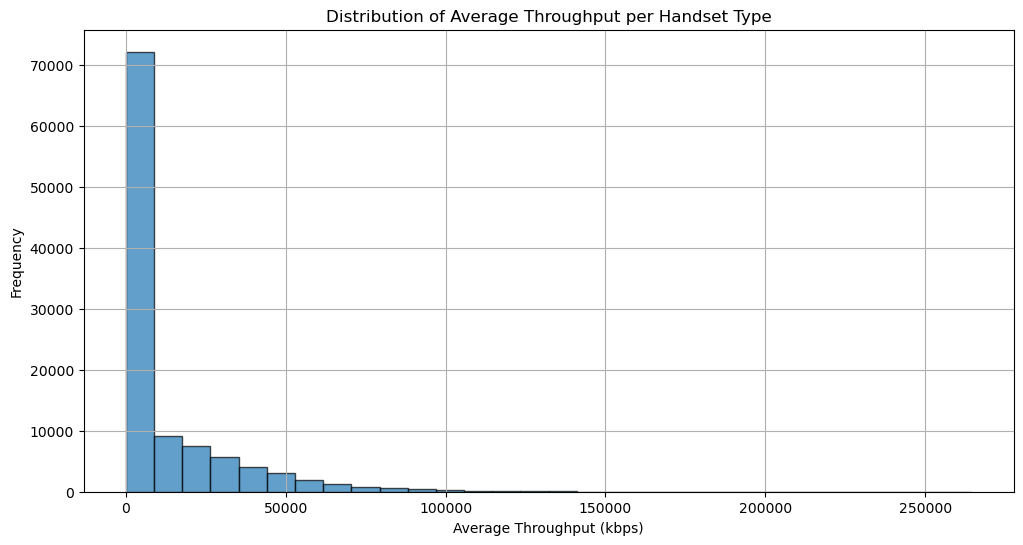

In [16]:
# Plot throughput distribution
plt.figure(figsize=(12, 6))
plt.hist(throughput_distribution, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Throughput per Handset Type')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

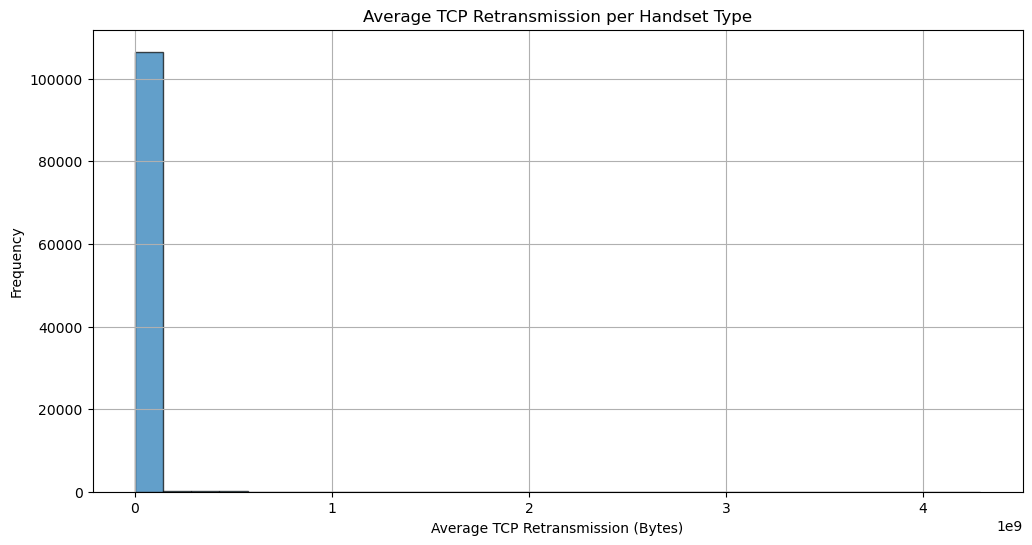

In [17]:
# Plot TCP retransmission distribution
plt.figure(figsize=(12, 6))
plt.hist(tcp_retransmission_distribution, bins=30, edgecolor='k', alpha=0.7)
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Average TCP Retransmission (Bytes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Perform K-means clustering

In [18]:
# Select features for clustering
features = agg_df[['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']]

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
agg_df['Experience Cluster'] = kmeans.labels_

# Cluster descriptions
for cluster in range(3):
    print(f"Cluster {cluster}:")
    print(agg_df[agg_df['Experience Cluster'] == cluster].describe())


Cluster 0:
       MSISDN/Number  TCP DL Retrans. Vol (Bytes)  \
count   1.065530e+05                 1.065530e+05   
mean    4.514731e+10                 1.581571e+07   
std     2.893529e+12                 2.011382e+07   
min     3.360100e+10                 2.000000e+00   
25%     3.365086e+10                 4.901141e+06   
50%     3.366364e+10                 2.080991e+07   
75%     3.368341e+10                 2.080991e+07   
max     8.823971e+14                 4.991983e+08   

       TCP UL Retrans. Vol (Bytes)  Avg RTT DL (ms)  Avg RTT UL (ms)  \
count                 1.065530e+05    106553.000000    106553.000000   
mean                  7.285051e+05       117.990845        16.726642   
std                   1.241057e+07       579.737424        73.568943   
min                   1.000000e+00         0.000000         0.000000   
25%                   2.957050e+05        35.000000         3.000000   
50%                   7.596587e+05        56.000000         7.000000   
75%    

Aggregated data and clustering results have been saved to 'aggregated_customer_experience.csv'.


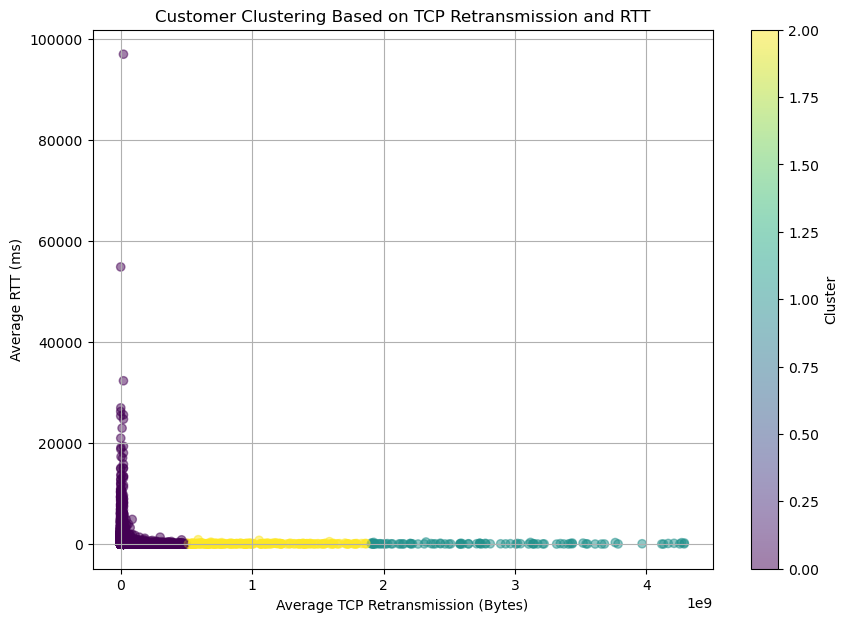

In [19]:
print("Aggregated data and clustering results have been saved to 'aggregated_customer_experience.csv'.")

# Cluster visualization (optional)
plt.figure(figsize=(10, 7))
plt.scatter(agg_df['TCP DL Retrans. Vol (Bytes)'], agg_df['Avg RTT DL (ms)'], 
            c=agg_df['Experience Cluster'], cmap='viridis', alpha=0.5)
plt.title('Customer Clustering Based on TCP Retransmission and RTT')
plt.xlabel('Average TCP Retransmission (Bytes)')
plt.ylabel('Average RTT (ms)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [20]:
# Define the 'least engaged' and 'worst experience' clusters based on assumptions (e.g., Cluster 2 might be the worst experience).
# Modify based on the actual analysis from Task 3.
worst_experience_cluster = 2  # Assumed worst experience cluster from Task 3
least_engaged_cluster = 0     # Assumed least engaged cluster from Task 3

## Engagement and Experience Scores

#### Engagement Score

In [21]:
# Engagement Score (distance from less engaged cluster)
# Use cluster 2 as the "less engaged" cluster (from Task 3)
cluster_centers = kmeans.cluster_centers_
less_engaged_cluster_center = cluster_centers[2]

# Calculate Euclidean distance between each user and the less engaged cluster
agg_df['Engagement Score'] = euclidean_distances(
    agg_df[['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']],
    [less_engaged_cluster_center]
).flatten()


In [22]:
agg_df['Engagement Score']

0         9.690184e+08
1         9.690184e+08
2         9.690184e+08
3         9.898273e+08
4         9.747486e+08
              ...     
106852    9.690184e+08
106853    9.732780e+08
106854    9.690184e+08
106855    9.690184e+08
106856    9.690184e+08
Name: Engagement Score, Length: 106857, dtype: float64

### Experience Score

In [23]:
# Experience Score (distance from worst experience cluster)
# Assuming cluster 2 is the "worst experience" cluster
worst_experience_cluster_center = cluster_centers[2]

# Calculate Euclidean distance between each user and the worst experience cluster
agg_df['Experience Score'] = euclidean_distances(
    agg_df[['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']],
    [worst_experience_cluster_center]
).flatten()

In [24]:

print(agg_df[['MSISDN/Number', 'Engagement Score', 'Experience Score']].head(10))



   MSISDN/Number  Engagement Score  Experience Score
0   3.360100e+10      9.690184e+08      9.690184e+08
1   3.360100e+10      9.690184e+08      9.690184e+08
2   3.360100e+10      9.690184e+08      9.690184e+08
3   3.360101e+10      9.898273e+08      9.898273e+08
4   3.360101e+10      9.747486e+08      9.747486e+08
5   3.360101e+10      9.794220e+08      9.794220e+08
6   3.360101e+10      9.793742e+08      9.793742e+08
7   3.360101e+10      9.898280e+08      9.898280e+08
8   3.360101e+10      9.690184e+08      9.690184e+08
9   3.360102e+10      9.690184e+08      9.690184e+08


### Calculate Satisfaction Score

In [25]:
# Satisfaction Score
agg_df['Satisfaction Score'] = agg_df[['Engagement Score', 'Experience Score']].mean(axis=1)

# Top 10 satisfied customers
top_10_satisfied_customers = agg_df[['MSISDN/Number', 'Satisfaction Score']].sort_values(by='Satisfaction Score', ascending=False).head(10)

print("Top 10 Satisfied Customers:\n", top_10_satisfied_customers)


Top 10 Satisfied Customers:
        MSISDN/Number  Satisfaction Score
85785   3.369858e+10        3.299659e+09
32273   3.365871e+10        3.298232e+09
58026   3.366491e+10        3.278604e+09
31942   3.365863e+10        3.264816e+09
62049   3.366613e+10        3.221361e+09
70079   3.366877e+10        3.176763e+09
43629   3.366131e+10        3.141217e+09
48341   3.366240e+10        3.127925e+09
64113   3.366682e+10        2.978244e+09
98211   3.376264e+10        2.795466e+09


In [26]:
#Top 10 satisfied customers
print(agg_df[['MSISDN/Number', 'Engagement Score', 'Experience Score', 'Satisfaction Score']].sort_values(by='Satisfaction Score', ascending=False).head(10))

       MSISDN/Number  Engagement Score  Experience Score  Satisfaction Score
85785   3.369858e+10      3.299659e+09      3.299659e+09        3.299659e+09
32273   3.365871e+10      3.298232e+09      3.298232e+09        3.298232e+09
58026   3.366491e+10      3.278604e+09      3.278604e+09        3.278604e+09
31942   3.365863e+10      3.264816e+09      3.264816e+09        3.264816e+09
62049   3.366613e+10      3.221361e+09      3.221361e+09        3.221361e+09
70079   3.366877e+10      3.176763e+09      3.176763e+09        3.176763e+09
43629   3.366131e+10      3.141217e+09      3.141217e+09        3.141217e+09
48341   3.366240e+10      3.127925e+09      3.127925e+09        3.127925e+09
64113   3.366682e+10      2.978244e+09      2.978244e+09        2.978244e+09
98211   3.376264e+10      2.795466e+09      2.795466e+09        2.795466e+09


### Build a Regression Model

#### Tranin test split

In [27]:
# Split the data into features (X) and target (y)
X = agg_df[['Engagement Score', 'Experience Score']]
y = agg_df['Satisfaction Score']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#### Model develop

In [28]:
# Check for NaN values in X_train
print("Checking for NaN values in X_train:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

# Check for NaN values in y_train
print("Checking for NaN values in y_train:")
print(y_train.isnull().sum())


Checking for NaN values in X_train:
Series([], dtype: int64)
Checking for NaN values in y_train:
0


In [29]:
# Train the regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

#### Model Evaluation

In [30]:
# Make prediction
y_pred = regression_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model MSE: {mse}")
print(f"Model R² Score: {r2}")


Model MSE: 1.892371402814985e-16
Model R² Score: 1.0


### K-Means Clustering on Engagement and Experience Scores

In [31]:
# K-means clustering on engagement & experience scores
kmeans_2 = KMeans(n_clusters=2, random_state=42)
agg_df['Engagement_Experience Cluster'] = kmeans_2.fit_predict(agg_df[['Engagement Score', 'Experience Score']])

# Print cluster centers for understanding
print("Cluster centers:\n", kmeans_2.cluster_centers_)


Cluster centers:
 [[9.75227185e+08 9.75227185e+08]
 [4.31925315e+08 4.31925315e+08]]


#### Aggregate Average Satisfaction and Experience Score per Cluster

In [32]:
# Aggregate average satisfaction & experience scores per cluster
cluster_averages = agg_df.groupby('Engagement_Experience Cluster')[['Satisfaction Score', 'Experience Score']].mean()
print("Average Satisfaction & Experience Scores per Cluster:\n", cluster_averages)


Average Satisfaction & Experience Scores per Cluster:
                                Satisfaction Score  Experience Score
Engagement_Experience Cluster                                      
0                                    9.752272e+08      9.752272e+08
1                                    4.319253e+08      4.319253e+08


#### Export to postgres